Dataset used:
https://www.kaggle.com/datasets/blastchar/telco-customer-churn

In [ ]:
import os
old_name = r"/content/WA_Fn-UseC_-Telco-Customer-Churn.csv"
new_name = r"/content/Churn.csv"
os.rename(old_name, new_name)

Imports and loading data

In [ ]:
!pip install catboost ydata-profiling

In [ ]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from ydata_profiling import ProfileReport
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import recall_score, confusion_matrix, precision_score, f1_score, accuracy_score, classification_report

In [ ]:
df=pd.read_csv('/content/Churn.csv')

Cleaning Data

In [ ]:
churn_report = ProfileReport(df)
churn_report

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
df = df.drop(['customerID'], axis=1)
df.head()

gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  Female              0     Yes         No       1           No   
1    Male              0      No         No      34          Yes   
2    Male              0      No         No       2          Yes   
3    Male              0      No         No      45           No   
4  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity OnlineBackup  \
0  No phone service             DSL             No          Yes   
1                No             DSL            Yes           No   
2                No             DSL            Yes          Yes   
3  No phone service             DSL            Yes           No   
4                No     Fiber optic             No           No   

  DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0               No          No          No              No  Month-to-month   
1              Yes          No          No              No        One year   
2               No          No          No              No  Month-to-month   
3              Yes         Yes          No              No        One year   
4               No          No          No              No  Month-to-month   

  PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges  \
0              Yes           Electronic check           29.85        29.85   
1               No               Mailed check           56.95       1889.5   
2              Yes               Mailed check           53.85       108.15   
3               No  Bank transfer (automatic)           42.30      1840.75   
4              Yes           Electronic check           70.70       151.65   

  Churn  
0    No  
1    No  
2   Yes  
3    No  
4   Yes

In [ ]:
#Some values of TotalCharges are characters such as "." instead of numbers. To find them, we are using pd.to_numeric, all non numeric values will become NaNs
df['TotalCharges'] = pd.to_numeric(df.TotalCharges, errors='coerce')
df.isnull().sum()

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [ ]:
df[np.isnan(df['TotalCharges'])]

gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
488   Female              0     Yes        Yes       0           No   
753     Male              0      No        Yes       0          Yes   
936   Female              0     Yes        Yes       0          Yes   
1082    Male              0     Yes        Yes       0          Yes   
1340  Female              0     Yes        Yes       0           No   
3331    Male              0     Yes        Yes       0          Yes   
3826    Male              0     Yes        Yes       0          Yes   
4380  Female              0     Yes        Yes       0          Yes   
5218    Male              0     Yes        Yes       0          Yes   
6670  Female              0     Yes        Yes       0          Yes   
6754    Male              0      No        Yes       0          Yes   

         MultipleLines InternetService       OnlineSecurity  \
488   No phone service             DSL                  Yes   
753                 No              No  No internet service   
936                 No             DSL                  Yes   
1082               Yes              No  No internet service   
1340  No phone service             DSL                  Yes   
3331                No              No  No internet service   
3826               Yes              No  No internet service   
4380                No              No  No internet service   
5218                No              No  No internet service   
6670               Yes             DSL                   No   
6754               Yes             DSL                  Yes   

             OnlineBackup     DeviceProtection          TechSupport  \
488                    No                  Yes                  Yes   
753   No internet service  No internet service  No internet service   
936                   Yes                  Yes                   No   
1082  No internet service  No internet service  No internet service   
1340                  Yes                  Yes                  Yes   
3331  No internet service  No internet service  No internet service   
3826  No internet service  No internet service  No internet service   
4380  No internet service  No internet service  No internet service   
5218  No internet service  No internet service  No internet service   
6670                  Yes                  Yes                  Yes   
6754                  Yes                   No                  Yes   

              StreamingTV      StreamingMovies  Contract PaperlessBilling  \
488                   Yes                   No  Two year              Yes   
753   No internet service  No internet service  Two year               No   
936                   Yes                  Yes  Two year               No   
1082  No internet service  No internet service  Two year               No   
1340                  Yes                   No  Two year               No   
3331  No internet service  No internet service  Two year               No   
3826  No internet service  No internet service  Two year               No   
4380  No internet service  No internet service  Two year               No   
5218  No internet service  No internet service  One year              Yes   
6670                  Yes                   No  Two year               No   
6754                   No                   No  Two year              Yes   

                  PaymentMethod  MonthlyCharges  TotalCharges Churn  
488   Bank transfer (automatic)           52.55           NaN    No  
753                Mailed check           20.25           NaN    No  
936                Mailed check           80.85           NaN    No  
1082               Mailed check           25.75           NaN    No  
1340    Credit card (automatic)           56.05           NaN    No  
3331               Mailed check           19.85           NaN    No  
3826               Mailed check           25.35           NaN    No  
4380               Mailed check           20.00           

In [ ]:
df.drop(labels=df[df['tenure'] == 0].index, axis=0, inplace=True)
df[df['tenure'] == 0].index

Index([], dtype='int64')

In [ ]:
# filling missing TotalCharges values with the mean of TotalCharged values
df.fillna(df["TotalCharges"].mean())

gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0     Female              0     Yes         No       1           No   
1       Male              0      No         No      34          Yes   
2       Male              0      No         No       2          Yes   
3       Male              0      No         No      45           No   
4     Female              0      No         No       2          Yes   
...      ...            ...     ...        ...     ...          ...   
7038    Male              0     Yes        Yes      24          Yes   
7039  Female              0     Yes        Yes      72          Yes   
7040  Female              0     Yes        Yes      11           No   
7041    Male              1     Yes         No       4          Yes   
7042    Male              0      No         No      66          Yes   

         MultipleLines InternetService OnlineSecurity OnlineBackup  \
0     No phone service             DSL             No          Yes   
1                   No             DSL            Yes           No   
2                   No             DSL            Yes          Yes   
3     No phone service             DSL            Yes           No   
4                   No     Fiber optic             No           No   
...                ...             ...            ...          ...   
7038               Yes             DSL            Yes           No   
7039               Yes     Fiber optic             No          Yes   
7040  No phone service             DSL            Yes           No   
7041               Yes     Fiber optic             No           No   
7042                No     Fiber optic            Yes           No   

     DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0                  No          No          No              No  Month-to-month   
1                 Yes          No          No              No        One year   
2                  No          No          No              No  Month-to-month   
3                 Yes         Yes          No              No        One year   
4                  No          No          No              No  Month-to-month   
...               ...         ...         ...             ...             ...   
7038              Yes         Yes         Yes             Yes        One year   
7039              Yes          No         Yes             Yes        One year   
7040               No          No          No              No  Month-to-month   
7041               No          No          No              No  Month-to-month   
7042              Yes         Yes         Yes             Yes        Two year   

     PaperlessBilling              PaymentMethod  MonthlyCharges  \
0                 Yes           Electronic check           29.85   
1                  No               Mailed check           56.95   
2                 Yes               Mailed check           53.85   
3                  No  Bank transfer (automatic)           42.30   
4                 Yes           Electronic check           70.70   
...               ...                        ...             ...   
7038              Yes               Mailed check           84.80   
7039              Yes    Credit card (automatic)          103.20   
7040              Yes           Electronic check           29.60   
7041              Yes               Mailed check           74.40   
7042              Yes  Bank transfer (automatic)          105.65   

      TotalCharges Churn  
0            29.85    No  
1          1889.50    No  
2           108.15   Yes  
3          1840.75    No  
4           151.65   Yes  
...            ...   ...  
7038       1990.50    No  
7039       7362.90    No  
7040        346.45    No  
7041        306.60   Yes  
7042       6844.50    No  

[7032 rows x 20 columns]

In [ ]:
df.isnull().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

EDA

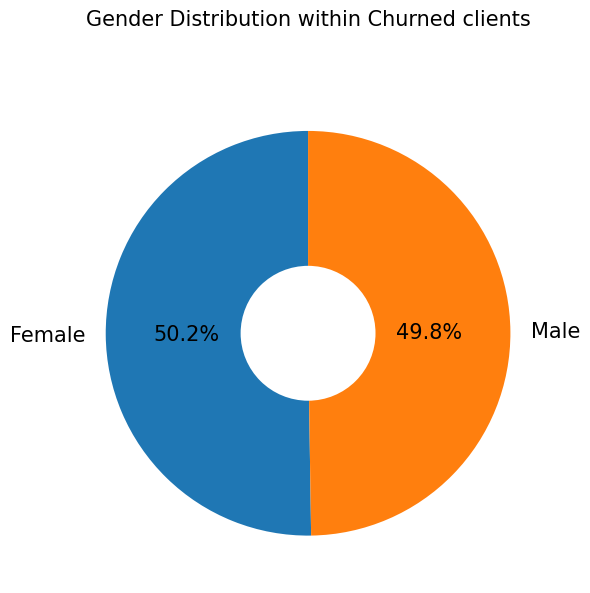

In [ ]:
plt.figure(figsize=(6, 6))

labels_gender = ["Female", "Male"]
sizes_gender = [939, 930]

textprops = {"fontsize": 15}

# Plot
plt.pie(sizes_gender, labels=labels_gender, startangle=90, radius=1.5, textprops=textprops, counterclock=True, autopct='%1.1f%%')

# Draw circle
centre_circle = plt.Circle((0, 0), .5, color='black', fc='white', linewidth=0)
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Gender Distribution within Churned customers', fontsize=15, y=1.1)

# Show plot
plt.axis('equal')
plt.tight_layout()
plt.show()

The negligible difference in churn rates between male and female customers suggests that gender is not a significant predictor of churn in this context.

In [ ]:
fig = px.histogram(df, x="Churn", color="SeniorCitizen", title="<b>Chrun distribution w.r.t. Senior Citizen</b>")
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

In [ ]:
senior_churned = df[df['SeniorCitizen'] == 1]['Churn'].value_counts()
fig = px.pie(hole = .4, names=senior_churned.index, values=senior_churned.values, title="Churn Distribution for Senior Citizens")
fig.update_traces(textfont_size=16)
fig.show()

There are very few senior citizen customers. More than half of them churn. This however, still isn't a good predictor for churn.

In [ ]:
fig = px.histogram(df, x="Churn", color="Partner", barmode="group", title="<b>Chrun distribution w.r.t. Partners</b>")
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

customers without partners are more likely to churn.

In [ ]:
fig = px.histogram(df, x="Churn", color="Dependents", barmode="group", title="<b>Dependents distribution</b>")
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

Non dependant customers are more likely to churn.

In [ ]:
import plotly.express as px

# Create a histogram
fig = px.histogram(df, x='tenure', color='Churn', title='Tenure vs Churn',
                   labels={'tenure': 'Tenure (Months)'},
                   color_discrete_map={"Yes": '#FF5733', "No": '#33FF57'})

# Update size and title
fig.update_layout(autosize=True, width=750, height=600,
                  title_font=dict(size=25, family='Courier'),
                  title='<b>Tenure vs Churn</b>')

fig.show()


In [ ]:
fig_box = px.box(df, x='Churn', y='tenure', title='Tenure vs Churn',
                 labels={'tenure': 'Tenure (Months)', 'Churn': 'Churn'},
                 color_discrete_map={"Yes": '#FF5733', "No": '#33FF57'})

fig_box.update_layout(autosize=True, width=750, height=600,
                      title_font=dict(size=25, family='Courier'),
                      title='<b>Tenure vs Churn (Box Plot)</b>')

fig_box.show()


In [ ]:
fig_violin = px.violin(df, x='Churn', y='tenure', title='Tenure vs Churn',
                       labels={'tenure': 'Tenure (Months)', 'Churn': 'Churn'},
                       color_discrete_map={"Yes": '#FF5733', "No": '#33FF57'})

fig_violin.update_layout(autosize=True, width=750, height=600,
                         title_font=dict(size=25, family='Courier'),
                         title='<b>Tenure vs Churn (Violin Plot)</b>')

fig_violin.show()


In [ ]:
import plotly.graph_objects as go
import numpy as np

churned_tenure = df[df['Churn'] == 'Yes']['tenure']
non_churned_tenure = df[df['Churn'] == 'No']['tenure']

fig_ecdf = go.Figure()

fig_ecdf.add_trace(go.Scatter(x=np.sort(churned_tenure), y=np.arange(1, len(churned_tenure) + 1) / len(churned_tenure),
                              mode='lines', name='Churn: Yes', line=dict(color='#FF5733')))
fig_ecdf.add_trace(go.Scatter(x=np.sort(non_churned_tenure), y=np.arange(1, len(non_churned_tenure) + 1) / len(non_churned_tenure),
                              mode='lines', name='Churn: No', line=dict(color='#33FF57')))

fig_ecdf.update_layout(autosize=True, width=750, height=600,
                       title='<b>ECDF of Tenure vs Churn</b>',
                       xaxis_title='Tenure (Months)', yaxis_title='ECDF')

fig_ecdf.show()


Newer customers are more likely to churn.

In [ ]:
fig = px.histogram(df, x="Churn", color="PhoneService", title="<b>Chrun distribution w.r.t. Phone Service</b>")
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

In [ ]:
import plotly.express as px

# Filter DataFrame for churn with PhoneService 'Yes' and 'No'
churn_phone_yes = df[df['PhoneService'] == 'Yes']['Churn'].value_counts()
churn_phone_no = df[df['PhoneService'] == 'No']['Churn'].value_counts()

# Create pie chart for PhoneService: Yes
fig_pie_yes = px.pie(hole = .4, names=churn_phone_yes.index, values=churn_phone_yes.values, title="Churn Distribution for PhoneService: Yes")
fig_pie_yes.update_traces(textposition='inside', textinfo='percent+label', textfont_size=16)

# Create pie chart for PhoneService: No
fig_pie_no = px.pie(hole = .4, names=churn_phone_no.index, values=churn_phone_no.values, title="Churn Distribution for PhoneService: No")
fig_pie_no.update_traces(textposition='inside', textinfo='percent+label', textfont_size=16)

# Show plots separately
fig_pie_yes.show()
fig_pie_no.show()



About 25% of customers with and without phone service churn every year. Not a good predictor for churn.

In [ ]:
# Create a histogram
fig_histogram = px.histogram(df, x='MultipleLines', color='Churn', title='Churn Distribution for MultipleLines',
                             labels={'MultipleLines': 'Multiple Lines', 'Churn': 'Churn'})

# Update size and title
fig_histogram.update_layout(autosize=True, width=750, height=600,
                             title_font=dict(size=25, family='Courier'),
                             title='<b>Churn Distribution for MultipleLines</b>')

fig_histogram.show()


customers who have multiple lines (yes and no) have similar churn counts.
customers who don't have phone service have lower churn rates.

In [ ]:
fig = go.Figure()

fig.add_trace(go.Bar(
  x = ['DSL', 'Fiber optic', 'No Internet'],
  y = [965, 889, 690],
  name = 'Churn: No',
))

fig.add_trace(go.Bar(
  x = ['DSL', 'Fiber optic', 'No Internet'],
  y = [219, 664, 56],
  name = 'Churn: Yes',
))

fig.update_layout(title_text="<b>Churn Distribution w.r.t. Internet Service</b>",
                  xaxis_title="Internet Service",
                  yaxis_title="Count")

fig.show()


customers with fiber optic have a very high churn rate, and customers with DSL have a lower churn rate.

In [ ]:
fig = px.histogram(df, x="Churn", color="Contract", barmode="group", title="<b>Customer contract distribution<b>")
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

customers with month-to-month contracts have a high churn rate.

In [ ]:
fig = px.histogram(df, x="Churn", color="PaymentMethod", title="<b>Customer Payment Method distribution w.r.t. Churn</b>")
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

customers with electronic check as their payment method are more likely to churn.

In [ ]:
fig = px.histogram(df, x="Churn", color="OnlineSecurity", barmode="group", title="<b>Churn w.r.t Online Security</b>")
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

customers churn when they don't have online security.

In [ ]:
fig = px.histogram(df, x="Churn", color="PaperlessBilling",  title="<b>Chrun distribution w.r.t. Paperless Billing</b>")
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

customers with paperless billing are more likely to churn.

In [ ]:
fig = px.histogram(df, x="Churn", color="TechSupport",barmode="group",  title="<b>Chrun distribution w.r.t. TechSupport</b>")
fig.update_layout(width=700, height=500, bargap=0.1)
fig.show()

customers are more likely to churn when tech support isn't provided.

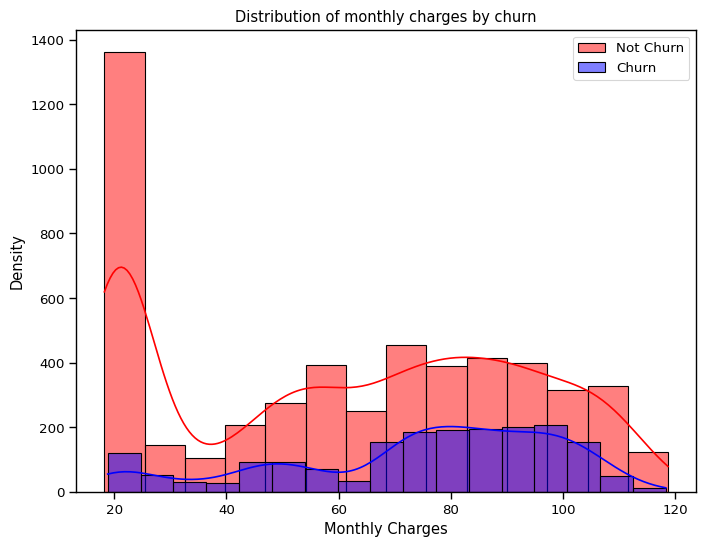

In [ ]:
sns.set_context("paper", font_scale=1.1)
plt.figure(figsize=(8, 6))

sns.histplot(df[df["Churn"] == 'No']["MonthlyCharges"], color="Red", kde=True, label="Not Churn", alpha=0.5)
sns.histplot(df[df["Churn"] == 'Yes']["MonthlyCharges"], color="Blue", kde=True, label="Churn", alpha=0.5)

plt.xlabel("Monthly Charges")
plt.ylabel("Density")
plt.title("Distribution of monthly charges by churn")
plt.legend()
plt.show()


In [ ]:
fig_box = px.box(df, x="Churn", y="MonthlyCharges",
                 title="Distribution of Monthly Charges by Churn",
                 labels={"MonthlyCharges": "Monthly Charges", "Churn": "Churn"},
                 color_discrete_map={"Yes": "blue", "No": "red"})
fig_box.update_layout(xaxis_title="Churn", yaxis_title="Monthly Charges")
fig_box.show()


customers with higher monthly charges are more likely to churn.

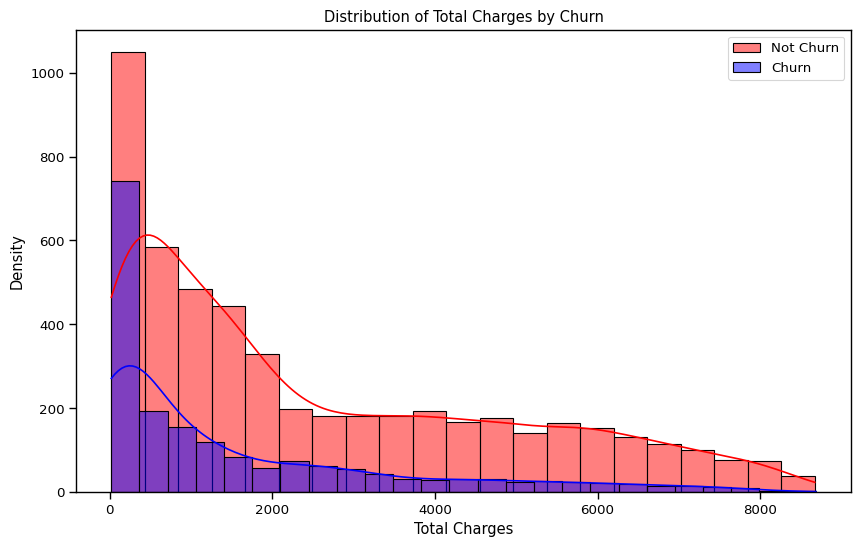

In [ ]:
plt.figure(figsize=(10, 6))
sns.set_context("paper", font_scale=1.1)

sns.histplot(df[df["Churn"] == 'No']["TotalCharges"], color="Red", kde=True, label="Not Churn", alpha=0.5)
sns.histplot(df[df["Churn"] == 'Yes']["TotalCharges"], color="Blue", kde=True, label="Churn", alpha=0.5)

plt.xlabel("Total Charges")
plt.ylabel("Density")
plt.title("Distribution of Total Charges by Churn")
plt.legend()
plt.show()


Model to predict churn.

Will make several models and choose one with bes accuracy

In [ ]:
def object_to_int(dataframe_series):
    if dataframe_series.dtype=='object':
        dataframe_series = LabelEncoder().fit_transform(dataframe_series)
    return dataframe_series

In [ ]:
df = df.apply(lambda x: object_to_int(x))
df.head()

gender  SeniorCitizen  Partner  Dependents  tenure  PhoneService  \
0       0              0        1           0       1             0   
1       1              0        0           0      34             1   
2       1              0        0           0       2             1   
3       1              0        0           0      45             0   
4       0              0        0           0       2             1   

   MultipleLines  InternetService  OnlineSecurity  OnlineBackup  \
0              1                0               0             2   
1              0                0               2             0   
2              0                0               2             2   
3              1                0               2             0   
4              0                1               0             0   

   DeviceProtection  TechSupport  StreamingTV  StreamingMovies  Contract  \
0                 0            0            0                0         0   
1                 2            0            0                0         1   
2                 0            0            0                0         0   
3                 2            2            0                0         1   
4                 0            0            0                0         0   

   PaperlessBilling  PaymentMethod  MonthlyCharges  TotalCharges  Churn  
0                 1              2           29.85         29.85      0  
1                 0              3           56.95       1889.50      0  
2                 1              3           53.85        108.15      1  
3                 0              0           42.30       1840.75      0  
4                 1              2           70.70        151.65      1

In [ ]:
plt.figure(figsize=(14,7))
df.corr()['Churn'].sort_values(ascending = False)

Churn               1.000000
MonthlyCharges      0.192858
PaperlessBilling    0.191454
SeniorCitizen       0.150541
PaymentMethod       0.107852
MultipleLines       0.038043
PhoneService        0.011691
gender             -0.008545
StreamingTV        -0.036303
StreamingMovies    -0.038802
InternetService    -0.047097
Partner            -0.149982
Dependents         -0.163128
DeviceProtection   -0.177883
OnlineBackup       -0.195290
TotalCharges       -0.199484
TechSupport        -0.282232
OnlineSecurity     -0.289050
tenure             -0.354049
Contract           -0.396150
Name: Churn, dtype: float64

<Figure size 1400x700 with 0 Axes>

In [ ]:
X = df.drop(columns = ['Churn'])
y = df['Churn'].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.30, random_state = 40, stratify=y)

In [ ]:
def distplot(feature, frame, color='r'):
    plt.figure(figsize=(8,3))
    plt.title("Distribution for {}".format(feature))
    ax = sns.distplot(frame[feature], color= color)

<ipython-input-42-8c8257b32bab>:4: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


<ipython-input-42-8c8257b32bab>:4: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


<ipython-input-42-8c8257b32bab>:4: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use ei

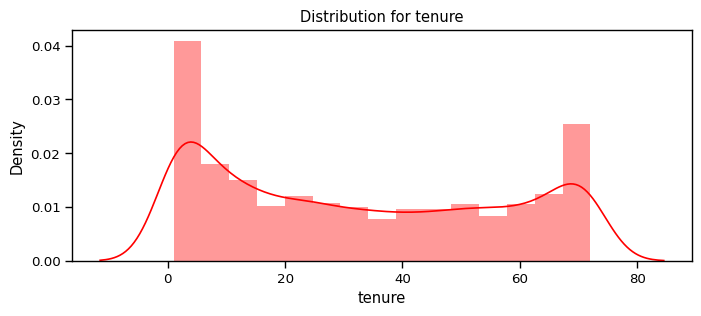

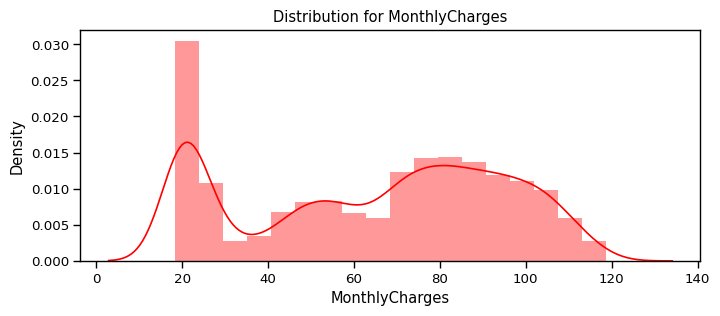

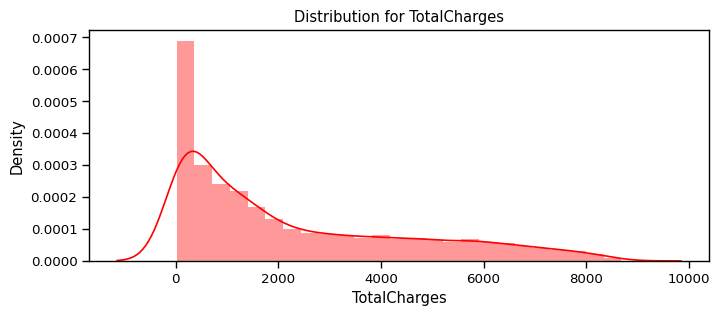

In [ ]:
num_cols = ["tenure", 'MonthlyCharges', 'TotalCharges']
for feat in num_cols: distplot(feat, df)

Use StandardScaler() to standardize numeric features

In [ ]:
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
df[numerical_cols].describe()

tenure  MonthlyCharges  TotalCharges
count  7032.000000     7032.000000   7032.000000
mean     32.421786       64.798208   2283.300441
std      24.545260       30.085974   2266.771362
min       1.000000       18.250000     18.800000
25%       9.000000       35.587500    401.450000
50%      29.000000       70.350000   1397.475000
75%      55.000000       89.862500   3794.737500
max      72.000000      118.750000   8684.800000

<ipython-input-42-8c8257b32bab>:4: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


<ipython-input-42-8c8257b32bab>:4: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


<ipython-input-42-8c8257b32bab>:4: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use ei

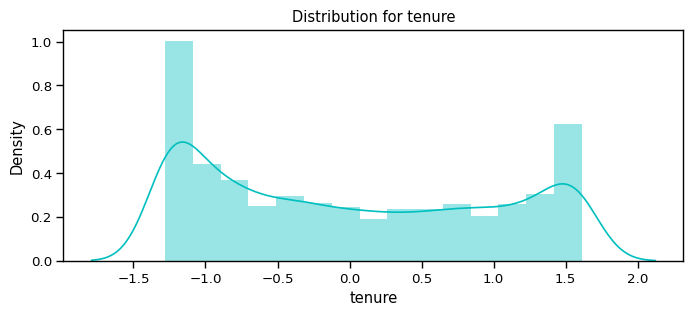

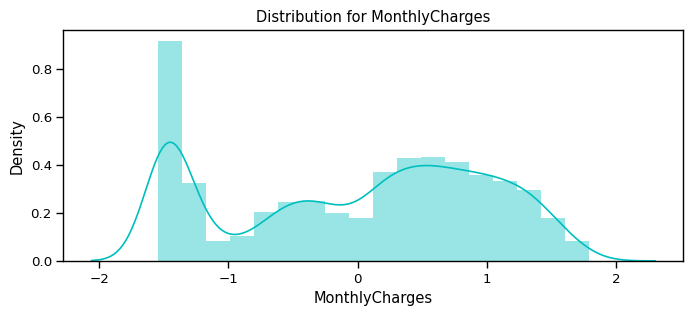

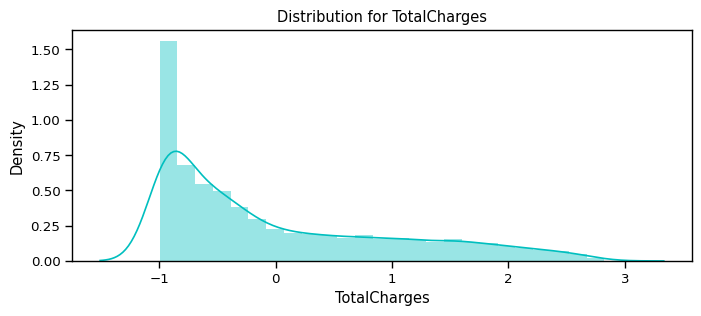

In [ ]:
df_std = pd.DataFrame(StandardScaler().fit_transform(df[num_cols].astype('float64')),
                       columns=num_cols)
for feat in numerical_cols: distplot(feat, df_std, color='c')

In [ ]:
cat_cols_ohe =['PaymentMethod', 'Contract', 'InternetService'] # those that need one-hot encoding
cat_cols_le = list(set(X_train.columns)- set(num_cols) - set(cat_cols_ohe)) #those that need label encoding

In [ ]:
scaler= StandardScaler()

X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

In [ ]:
svc_model = SVC(random_state = 1)
svc_model.fit(X_train,y_train)
predict_y = svc_model.predict(X_test)
accuracy_svc = svc_model.score(X_test,y_test)
print("SVM accuracy is :",accuracy_svc)

SVM accuracy is : 0.8075829383886256


In [ ]:
print(classification_report(y_test, predict_y))

              precision    recall  f1-score   support

           0       0.84      0.92      0.88      1549
           1       0.69      0.50      0.58       561

    accuracy                           0.81      2110
   macro avg       0.76      0.71      0.73      2110
weighted avg       0.80      0.81      0.80      2110



In [ ]:
model_rf = RandomForestClassifier(n_estimators=500 , oob_score = True, n_jobs = -1,
                                  random_state =50, max_leaf_nodes = 30)
model_rf.fit(X_train, y_train)

# Make predictions
prediction_test = model_rf.predict(X_test)
print (metrics.accuracy_score(y_test, prediction_test))

0.8137440758293839


In [ ]:
print(classification_report(y_test, prediction_test))

              precision    recall  f1-score   support

           0       0.84      0.92      0.88      1549
           1       0.71      0.51      0.59       561

    accuracy                           0.81      2110
   macro avg       0.77      0.72      0.74      2110
weighted avg       0.80      0.81      0.80      2110



In [ ]:
# Initialize and train GBM model
gbm_model = GradientBoostingClassifier(random_state=42)
gbm_model.fit(X_train, y_train)

# Predict
y_pred_gbm = gbm_model.predict(X_test)

# Calculate accuracy
accuracy_gbm = accuracy_score(y_test, y_pred_gbm)
print("GBM Model Accuracy:", accuracy_gbm)


GBM Model Accuracy: 0.8080568720379147


In [ ]:
print(classification_report(y_test, y_pred_gbm))

              precision    recall  f1-score   support

           0       0.85      0.90      0.87      1549
           1       0.67      0.55      0.60       561

    accuracy                           0.81      2110
   macro avg       0.76      0.73      0.74      2110
weighted avg       0.80      0.81      0.80      2110



In [ ]:
xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)

# Predict
y_pred_xgb = xgb_model.predict(X_test)

# Calculate accuracy
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print("XGBoost Model Accuracy:", accuracy_xgb)

XGBoost Model Accuracy: 0.7786729857819905


In [ ]:
print(classification_report(y_test, y_pred_xgb))


              precision    recall  f1-score   support

           0       0.84      0.86      0.85      1549
           1       0.59      0.55      0.57       561

    accuracy                           0.78      2110
   macro avg       0.72      0.71      0.71      2110
weighted avg       0.77      0.78      0.78      2110



In [ ]:
a_model = AdaBoostClassifier()
a_model.fit(X_train,y_train)
a_preds = a_model.predict(X_test)
print("AdaBoost Classifier accuracy")
metrics.accuracy_score(y_test, a_preds)

AdaBoost Classifier accuracy


0.8075829383886256

In [ ]:
print(classification_report(y_test, a_preds))

              precision    recall  f1-score   support

           0       0.85      0.90      0.87      1549
           1       0.67      0.55      0.60       561

    accuracy                           0.81      2110
   macro avg       0.76      0.72      0.74      2110
weighted avg       0.80      0.81      0.80      2110



In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import accuracy_score

# Define the neural network architecture
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

# Evaluate the model
y_pred_nn = (model.predict(X_test) > 0.5).astype("int32")
accuracy_nn = accuracy_score(y_test, y_pred_nn)
print("Neural Network Model Accuracy:", accuracy_nn)


Epoch 1/20
124/124 [==============================] - 2s 6ms/step - loss: 0.5124 - accuracy: 0.7432 - val_loss: 0.4406 - val_accuracy: 0.7858
Epoch 2/20
124/124 [==============================] - 0s 4ms/step - loss: 0.4580 - accuracy: 0.7734 - val_loss: 0.4310 - val_accuracy: 0.7939
Epoch 3/20
124/124 [==============================] - 0s 4ms/step - loss: 0.4468 - accuracy: 0.7821 - val_loss: 0.4286 - val_accuracy: 0.7959
Epoch 4/20
124/124 [==============================] - 0s 3ms/step - loss: 0.4390 - accuracy: 0.7864 - val_loss: 0.4256 - val_accuracy: 0.8041
Epoch 5/20
124/124 [==============================] - 0s 3ms/step - loss: 0.4358 - accuracy: 0.7938 - val_loss: 0.4280 - val_accuracy: 0.7959
Epoch 6/20
124/124 [==============================] - 0s 4ms/step - loss: 0.4341 - accuracy: 0.7948 - val_loss: 0.4276 - val_accuracy: 0.7980
Epoch 7/20
124/124 [==============================] - 0s 3ms/step - loss: 0.4270 - accuracy: 0.7943 - val_loss: 0.4283 - val_accuracy: 0.7970
Epoch 

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score

# Define the neural network architecture
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

# Train the model with EarlyStopping callback
history = model.fit(X_train, y_train, epochs=500, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

# Evaluate the model
y_pred = (model.predict(X_test) > 0.5).astype("int32")
accuracy = accuracy_score(y_test, y_pred)
print("Neural Network Model Accuracy:", accuracy)


Epoch 1/500
124/124 [==============================] - 2s 5ms/step - loss: 0.5063 - accuracy: 0.7455 - val_loss: 0.4348 - val_accuracy: 0.7990
Epoch 2/500
124/124 [==============================] - 1s 4ms/step - loss: 0.4481 - accuracy: 0.7795 - val_loss: 0.4311 - val_accuracy: 0.7909
Epoch 3/500
124/124 [==============================] - 1s 6ms/step - loss: 0.4424 - accuracy: 0.7813 - val_loss: 0.4269 - val_accuracy: 0.7909
Epoch 4/500
124/124 [==============================] - 1s 6ms/step - loss: 0.4402 - accuracy: 0.7864 - val_loss: 0.4268 - val_accuracy: 0.8000
Epoch 5/500
124/124 [==============================] - 1s 8ms/step - loss: 0.4326 - accuracy: 0.7935 - val_loss: 0.4312 - val_accuracy: 0.7939
Epoch 6/500
124/124 [==============================] - 1s 6ms/step - loss: 0.4322 - accuracy: 0.7910 - val_loss: 0.4263 - val_accuracy: 0.7990
Epoch 7/500
124/124 [==============================] - 1s 8ms/step - loss: 0.4295 - accuracy: 0.7950 - val_loss: 0.4267 - val_accuracy: 0.7970

In [ ]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten
import numpy as np

# Assuming X_train and X_test are Pandas DataFrames containing numerical data
# Convert them to NumPy arrays before reshaping

X_train_np = X_train.to_numpy()
X_test_np = X_test.to_numpy()




# Define a convolutional neural network
model_cnn = Sequential([
    Conv1D(64, 3, activation='relu', input_shape=(X_train.shape[1], 1)),
    MaxPooling1D(2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compile the model
model_cnn.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

# Reshape the data for the CNN model
X_train_cnn = X_train_np.reshape((X_train_np.shape[0], X_train_np.shape[1], 1))
X_test_cnn = X_test_np.reshape((X_test_np.shape[0], X_test_np.shape[1], 1))

# Train the model
history_cnn = model_cnn.fit(X_train_cnn, y_train, epochs=20, batch_size=32, validation_split=0.2)

# Evaluate the model
y_pred_cnn = (model_cnn.predict(X_test_cnn) > 0.5).astype("int32")
accuracy_cnn = accuracy_score(y_test, y_pred_cnn)
print("CNN Model Accuracy:", accuracy_cnn)


Epoch 1/20
124/124 [==============================] - 2s 6ms/step - loss: 0.4825 - accuracy: 0.7623 - val_loss: 0.4282 - val_accuracy: 0.8020
Epoch 2/20
124/124 [==============================] - 1s 4ms/step - loss: 0.4400 - accuracy: 0.7927 - val_loss: 0.4310 - val_accuracy: 0.7919
Epoch 3/20
124/124 [==============================] - 1s 4ms/step - loss: 0.4334 - accuracy: 0.7953 - val_loss: 0.4229 - val_accuracy: 0.8020
Epoch 4/20
124/124 [==============================] - 1s 4ms/step - loss: 0.4294 - accuracy: 0.7920 - val_loss: 0.4242 - val_accuracy: 0.8061
Epoch 5/20
124/124 [==============================] - 1s 5ms/step - loss: 0.4252 - accuracy: 0.7940 - val_loss: 0.4234 - val_accuracy: 0.8020
Epoch 6/20
124/124 [==============================] - 1s 4ms/step - loss: 0.4280 - accuracy: 0.7960 - val_loss: 0.4340 - val_accuracy: 0.7990
Epoch 7/20
124/124 [==============================] - 1s 5ms/step - loss: 0.4260 - accuracy: 0.7960 - val_loss: 0.4234 - val_accuracy: 0.8010
Epoch 

In [ ]:
from tensorflow.keras.layers import LSTM

X_train_np = X_train.to_numpy()
X_test_np = X_test.to_numpy()


# Define a recurrent neural network
model_rnn = Sequential([
    LSTM(64, activation='relu', input_shape=(X_train.shape[1], 1)),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compile the model
model_rnn.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

# Reshape input data for RNN
X_train_rnn = X_train_np.reshape((X_train_np.shape[0], X_train_np.shape[1], 1))
X_test_rnn = X_test_np.reshape((X_test_np.shape[0], X_test_np.shape[1], 1))

# Train the model
history_rnn = model_rnn.fit(X_train_rnn, y_train, epochs=20, batch_size=32, validation_split=0.2)

# Evaluate the model
y_pred_rnn = (model_rnn.predict(X_test_rnn) > 0.5).astype("int32")
accuracy_rnn = accuracy_score(y_test, y_pred_rnn)
print("RNN Model Accuracy:", accuracy_rnn)


Epoch 1/20
124/124 [==============================] - 4s 17ms/step - loss: 0.5797 - accuracy: 0.7160 - val_loss: 0.5054 - val_accuracy: 0.7563
Epoch 2/20
124/124 [==============================] - 2s 19ms/step - loss: 0.5276 - accuracy: 0.7280 - val_loss: 0.4934 - val_accuracy: 0.7563
Epoch 3/20
124/124 [==============================] - 2s 17ms/step - loss: 0.5050 - accuracy: 0.7325 - val_loss: 0.4767 - val_accuracy: 0.7563
Epoch 4/20
124/124 [==============================] - 2s 13ms/step - loss: 0.4843 - accuracy: 0.7600 - val_loss: 0.4709 - val_accuracy: 0.7655
Epoch 5/20
124/124 [==============================] - 2s 13ms/step - loss: 0.4763 - accuracy: 0.7722 - val_loss: 0.4686 - val_accuracy: 0.7726
Epoch 6/20
124/124 [==============================] - 2s 13ms/step - loss: 0.4730 - accuracy: 0.7747 - val_loss: 0.4656 - val_accuracy: 0.7716
Epoch 7/20
124/124 [==============================] - 2s 14ms/step - loss: 0.4699 - accuracy: 0.7755 - val_loss: 0.4630 - val_accuracy: 0.7746

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score

# Assuming you have pre-trained neural network models named nn_model1, nn_model2, nn_model3

# Predictions from each model
pred_model1 = model_rf.predict(X_test)
pred_model2 = gbm_model.predict(X_test)
pred_model3 = a_model.predict(X_test)

# Create a VotingClassifier ensemble
voting_clf = VotingClassifier(estimators=[
    ('model1', model_rf),
    ('model2', gbm_model),
    ('model3', a_model)
], voting='soft')

# Fit the ensemble on training data (if needed)
voting_clf.fit(X_train, y_train)

# Make predictions with the ensemble
ensemble_pred = voting_clf.predict(X_test)

# Evaluate accuracy
ensemble_accuracy = accuracy_score(y_test, ensemble_pred)
print("Ensemble Accuracy:", ensemble_accuracy)


Ensemble Accuracy: 0.8118483412322275


The random forest model has the highest accuracy and can be used to predict customers most likely to churn.